<p style="font-family: monospace;
          font-weight: bold;
          letter-spacing: 1px;
          color: black;
          font-size: 200%;
          text-align: left;
          padding: 0px;
          border-bottom: 5px solid #fec89a" >Table of Contents</p>

* [Data and Cohort Characteristics](#section-one)
* [Exploratory Data Analysis (EDA)](#section-two)
* [Data Set and Data Loader](#section-three)
* [PyTorch Model](#section-four)
* [Training Loop](#section-five)
* [Evaluation](#section-six)
* [Conclusion](#section-seven)

<p style="font-family: monospace;
          font-weight: bold;
          letter-spacing: 1px;
          color: black;
          font-size: 200%;
          text-align: left;
          padding: 0px;
          border-bottom: 5px solid #fec89a" >RSNA Breast Cancer Detection with PyTorch</p>
          
My primary motivation behind creating this notebook was to get more practice using PyTorch. The prediction task in this notebook is to predict the presence or absence of cancer in the mammography images. The model I trained leverages both imaging and tabular data to make predictions.

In [1]:
pip install pydicom


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lets-plot

In [4]:
pip install torchvision

In [5]:
import os
import torch
import random
import pydicom
import torchvision
import numpy as np
import torch.nn as nn
import statistics as stats
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from PIL import Image
from PIL import Image
from lets_plot import *
from torchvision import transforms
from sklearn.metrics import confusion_matrix
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from lets_plot.mapping import as_discrete
from torch.utils.data import Dataset, DataLoader

# So the plots look nice
LetsPlot.setup_html()


<a id="section-one"></a>
<p style="font-family: monospace;
          font-weight: bold;
          letter-spacing: 1px;
          color: black;
          font-size: 200%;
          text-align: left;
          padding: 0px;
          border-bottom: 5px solid #fec89a" >Data and Cohort Characteristics</p>

In [6]:
# Data
df_train = pd.read_csv('C:/Users/ADMIN/Desktop/data/train.csv')
df_test = pd.read_csv('C:/Users/ADMIN/Desktop/data/test.csv')


In [7]:
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [8]:
print('Missing values by column')
print(df_train.isnull().sum())


Missing values by column
site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64


<a id="section-two"></a>
<p style="font-family: monospace;
          font-weight: bold;
          letter-spacing: 1px;
          color: black;
          font-size: 200%;
          text-align: left;
          padding: 0px;
          border-bottom: 5px solid #fec89a" >Exploratory Data Analysis (EDA)</p>

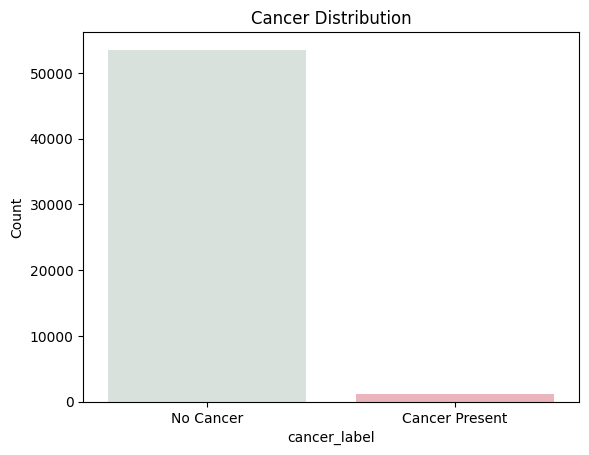

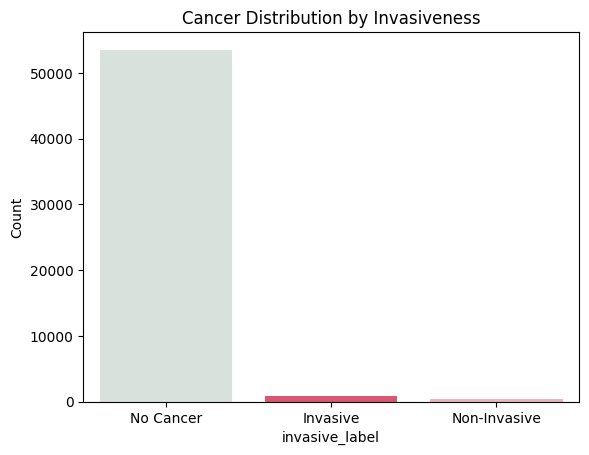

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu sử dụng pandas
df_train = pd.read_csv('C:/Users/ADMIN/Desktop/data/train.csv')
df_test = pd.read_csv('C:/Users/ADMIN/Desktop/data/test.csv')

# Tạo các cột mới cho labels
df_train['cancer_label'] = df_train['cancer'].map({1: 'Cancer Present', 0: 'No Cancer'})
df_train['invasive_label'] = df_train.apply(lambda x: 'Invasive' if x['cancer'] == 1 and x['invasive'] == 1 else ('Non-Invasive' if x['cancer'] == 1 else 'No Cancer'), axis=1)

# Khởi tạo màu sắc
color1 = '#d8e2dc'
color2 = '#f4acb7'
color3 = '#ee4266'

# Vẽ biểu đồ phân bố cancer
sns.countplot(x='cancer_label', data=df_train, palette=[color1, color2])
plt.title('Cancer Distribution')
plt.ylabel('Count')
plt.show()

# Vẽ biểu đồ phân bố cancer theo tính xâm lấn
sns.countplot(x='invasive_label', data=df_train, palette=[color1, color3, color2])
plt.title('Cancer Distribution by Invasiveness')
plt.ylabel('Count')
plt.show()


<a id="section-three"></a>
<p style="font-family: monospace;
          font-weight: bold;
          letter-spacing: 1px;
          color: black;
          font-size: 200%;
          text-align: left;
          padding: 0px;
          border-bottom: 5px solid #fec89a" >Data Set and Data Loader</p>
          
[Another notebook](https://www.kaggle.com/code/theoviel/dicom-resized-png-jpg) previously converted all the dicom files into 256x256 png files. Instead of re-creating the code I simply imported the data set (which can be found [here](https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-256-pngs)). Since my time is limited I decided to downsample the data set so the target is balanced.

A number of additional pre-processing techniques were applied:
* Missing values in the 'age' metadata column were imputed using the mean
* The view, laterality, and implant features were dummy encoded
* A column with the image filenames was added to the df

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Đọc dữ liệu
df_train = pd.read_csv('C:/Users/ADMIN/Desktop/data/train.csv')

# Downsampling những mẫu không mắc bệnh (cancer == 0)
df_target1 = df_train[df_train['cancer'] == 1]
df_target0 = df_train[df_train['cancer'] == 0].sample(n=len(df_target1), random_state=42)

# Tạo DataFrame cuối cùng từ những mẫu đã downsample
df_final = pd.concat([df_target1, df_target0])

# Đảo trộn dữ liệu
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Imputing giá trị tuổi bị thiếu và chuẩn hóa cột 'age'
df_final['age'] = df_final['age'].fillna(df_final['age'].mean())
df_final['age'] = (df_final['age'] - df_final['age'].min()) / (df_final['age'].max() - df_final['age'].min())

# Tạo các biến giả (one-hot encoding) cho các cột phân loại
df_final = pd.get_dummies(df_final, columns=['view', 'laterality', 'implant'])

# Thêm cột chỉ định dữ liệu là tập train hoặc valid
df_final['trainvalid'] = np.where(np.arange(len(df_final)) < round(len(df_final) * 0.8), 'train', 'valid')

# Tạo tên file dựa trên patient_id và image_id
df_final['fname'] = df_final['patient_id'].astype(str) + '_' + df_final['image_id'].astype(str)

# Tách dữ liệu thành tập train và valid
df_train_meta = df_final[df_final['trainvalid'] == 'train']
df_valid_meta = df_final[df_final['trainvalid'] == 'valid']

# Lấy tên file và nhãn cho tập train và valid
train_fnames = df_train_meta['fname'].values
valid_fnames = df_valid_meta['fname'].values
train_labels = df_train_meta['cancer'].values
valid_labels = df_valid_meta['cancer'].values

# Lưu các DataFrame thành file CSV nếu cần
df_train_meta.to_csv('C:/Users/ADMIN/Desktop/data/train_meta.csv', index=False)
df_valid_meta.to_csv('C:/Users/ADMIN/Desktop/data/valid_meta.csv', index=False)

# Hiển thị một số thông tin
print("Train filenames:", train_fnames[:5])
print("Train labels:", train_labels[:5])
print("Validation filenames:", valid_fnames[:5])
print("Validation labels:", valid_labels[:5])


Train filenames: ['5820_317530806' '37213_238138823' '14769_1515963059' '53343_1721695713'
 '23101_22058316']
Train labels: [1 1 1 1 1]
Validation filenames: ['56308_224574481' '34992_204545103' '2346_129609192' '29410_925338778'
 '27861_1532982826']
Validation labels: [1 1 1 0 1]


In [11]:
from PIL import Image
import os

print('Validation Metadata Characteristics')
print(df_valid_meta.info())

print('Training Metadata Characteristics')
print(df_train_meta.info())

Validation Metadata Characteristics
<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 1853 to 2315
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  463 non-null    int64  
 1   patient_id               463 non-null    int64  
 2   image_id                 463 non-null    int64  
 3   age                      463 non-null    float64
 4   cancer                   463 non-null    int64  
 5   biopsy                   463 non-null    int64  
 6   invasive                 463 non-null    int64  
 7   BIRADS                   231 non-null    float64
 8   density                  239 non-null    object 
 9   machine_id               463 non-null    int64  
 10  difficult_negative_case  463 non-null    bool   
 11  view_AT                  463 non-null    uint8  
 12  view_CC                  463 non-null    uint8  
 13  view_MLO                 463 non-null   

In [12]:
pip install tqdm 

Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
from PIL import Image
from shutil import copyfile

# Đường dẫn đến thư mục chứa ảnh
img_dir = 'C:/Users/ADMIN/Desktop/data/'

# Đọc thông tin từ các file metadata
df_train_meta = pd.read_csv('C:/Users/ADMIN/Desktop/data/train_meta.csv')
df_valid_meta = pd.read_csv('C:/Users/ADMIN/Desktop/data/valid_meta.csv')

# Tạo cột 'image_filename' nếu nó chưa tồn tại
df_train_meta['image_filename'] = df_train_meta['patient_id'].astype(str) + '_' + df_train_meta['image_id'].astype(str) + '.png'
df_valid_meta['image_filename'] = df_valid_meta['patient_id'].astype(str) + '_' + df_valid_meta['image_id'].astype(str) + '.png'

# Đường dẫn đến thư mục đích cho ảnh train và valid
train_dir = 'C:/Users/ADMIN/Desktop/data/train_images'
valid_dir = 'C:/Users/ADMIN/Desktop/data/valid_images'

# Tạo thư mục train và valid nếu chúng chưa tồn tại
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Di chuyển hình ảnh vào thư mục đích
for filename in df_train_meta['image_filename']:
    src_file_path = os.path.join(img_dir, filename)
    dst_file_path = os.path.join(train_dir, filename)
    if os.path.isfile(src_file_path):  # Kiểm tra xem file có tồn tại
        copyfile(src_file_path, dst_file_path)

for filename in df_valid_meta['image_filename']:
    src_file_path = os.path.join(img_dir, filename)
    dst_file_path = os.path.join(valid_dir, filename)
    if os.path.isfile(src_file_path):  # Kiểm tra xem file có tồn tại
        copyfile(src_file_path, dst_file_path)

print(f'Total images in train directory: {len(os.listdir(train_dir))}')
print(f'Total images in valid directory: {len(os.listdir(valid_dir))}')

Total images in train directory: 54706
Total images in valid directory: 463


In [14]:
# Defining the data set
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MammographyDataset(Dataset):
    def __init__(self, meta_df, img_dir, transform=None):
        
        self.df = meta_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get label from meta data
        label = self.df.iloc[idx]['cancer']
        img_filename = self.df.iloc[idx]['image_filename']  # make sure this column exists in your dataframe

        # Load image
        img_path = os.path.join(self.img_dir, img_filename)
        try:
            with Image.open(img_path) as img:
                if self.transform:
                    img = self.transform(img)
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            return None
            
        # Get metadata features
        feature_names = [
            'age', 
            'laterality_L', 'laterality_R', 
            'view_AT', 'view_CC', 'view_MLO',
            'implant_0', 'implant_1'
                        ]
        
        meta_features = self.df[feature_names]
        meta_features = meta_features.iloc[idx, :].to_numpy()

        
        return img, meta_features, label

# Defining the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Initialize the datasets
train_dataset = MammographyDataset(
    meta_df=df_train_meta,
    img_dir='C:/Users/ADMIN/Desktop/data/train_images',
    transform=transform,
)

valid_dataset = MammographyDataset(
    meta_df=df_valid_meta,
    img_dir='C:/Users/ADMIN/Desktop/data/valid_images',
    transform=transform,
)

# Initialize the DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)


<a id="section-four"></a>
<p style="font-family: monospace;
          font-weight: bold;
          letter-spacing: 1px;
          color: black;
          font-size: 200%;
          text-align: left;
          padding: 0px;
          border-bottom: 5px solid #fec89a" >PyTorch Model</p>
          
The PyTorch model below leverages both the imaging data and the meta data to make predictions. More specifically, it uses the age, laterality, view, and implant features from the meta data. Previously age was min-max scaled and the remaining meta features were dummy encoded.

A pre-trained ResNet50 model was used to output predicted probabilities which were then combined with the meta-data features and used as inputs to a fully connected network that returned the final predictions.

In [15]:
class MammographyModel(nn.Module):
    def __init__(self):
        super().__init__()

        # ResNet50
        self.rnet = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.rnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.rnet.fc = torch.nn.Linear(in_features=2048, out_features=500)

        # Final classification network
        self.fc1 = nn.Linear(508, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img, meta_features):

        # ResNet50
        resnet_out = self.rnet(img)
        resnet_out = torch.sigmoid(resnet_out)

        # Reshape meta features
        meta_features = meta_features.squeeze(1)

        # Get final predictions
        x_final = torch.cat((resnet_out, meta_features), dim=1).to(torch.float32)
        x_final = self.fc1(x_final)

        out = self.sigmoid(x_final)

        return out

model = MammographyModel()

In [16]:
# Loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

<a id="section-five"></a>
<p style="font-family: monospace;
          font-weight: bold;
          letter-spacing: 1px;
          color: black;
          font-size: 200%;
          text-align: left;
          padding: 0px;
          border-bottom: 5px solid #fec89a" >Training Loop</p>
          
          
Below is the training loop fo the ResNet50 model. I did not try and adjust the hyperparameters or architecture to improve the performance as the main aim was to simply get more practice writing PyTorch code.

In [17]:
# Handle the device stuff
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f'Using device: {device}')

Using device: cpu


In [ ]:
# Initialize number of epochs
import os
model_save_dir = 'C:/Users/ADMIN/Desktop/saved_models'
os.makedirs(model_save_dir, exist_ok=True)

npochs = 25
train_loss, valid_loss = [], []
train_accuracy, valid_accuracy = [], []
train_sensitivity, valid_sensitivity = [], []
train_specificity, valid_specificity = [], []

# Helper function
def get_sens_spec(y_true, y_pred):
    '''
    Returns the sensitivity and specificity given
    labels and class predictions
    '''

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return sensitivity, specificity

# Training loop
for epoch in range(npochs):

    # Training section
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for batch, (img, meta_features, label) in enumerate(train_loader):
        img = img.to(device)
        meta_features = meta_features.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        outputs = model(img, meta_features)

        loss = loss_fn(outputs.squeeze(), label.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store preds and labels
        preds = outputs.squeeze().detach().cpu().numpy().round()
        train_preds.extend(preds)
        train_labels.extend(label.cpu().numpy())

        if batch%5 == 0:
            print(f'epoch {epoch + 1}  batch {batch + 1}  train loss: {loss.item():10.8f}')

    # Save performance metrics
    train_sens, train_spec = get_sens_spec(train_labels, train_preds)
    train_sensitivity.append(train_sens)
    train_specificity.append(train_spec)
    avg_train_loss = running_loss/len(train_loader)
    train_loss.append(avg_train_loss)
    train_accuracy.append(accuracy_score(train_labels, train_preds))

    # Eval section
    model.eval()
    running_loss = 0.0
    valid_preds, valid_labels = [], []

    with torch.no_grad():
        for batch, (img, meta_features, label) in enumerate(valid_loader):
            img = img.to(device)
            meta_features = meta_features.to(device)
            label = label.to(device)

            outputs = model(img, meta_features)
            loss = loss_fn(outputs.squeeze(), label.float())

            running_loss += loss.item()

            # Store preds and labels
            preds = outputs.squeeze().detach().cpu().numpy().round()
            valid_preds.extend(preds)
            valid_labels.extend(label.cpu().numpy())

    # Save performance metrics
    valid_sens, valid_spec = get_sens_spec(valid_labels, valid_preds)
    valid_sensitivity.append(valid_sens)
    valid_specificity.append(valid_spec)
    avg_valid_loss = running_loss/len(valid_loader)
    valid_loss.append(avg_valid_loss)
    valid_accuracy.append(accuracy_score(valid_labels, valid_preds))

    print(f'---------------------------------------------------------------------------------')
    print(f'Metrics for epoch {epoch + 1}')
    print(f'Accuracy     train: {train_accuracy[epoch]}  valid: {valid_accuracy[epoch]}')
    print(f'Sensitivity  train: {train_sensitivity[epoch]}  valid: {valid_sensitivity[epoch]}')
    print(f'Specificity  train: {train_specificity[epoch]}  valid: {valid_specificity[epoch]}')
    print(f'---------------------------------------------------------------------------------')
    
    model_save_path = os.path.join(model_save_dir, f'model_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f'Model for epoch {epoch + 1} has been saved to {model_save_path}')


epoch 1  batch 1  train loss: 0.69855487
epoch 1  batch 6  train loss: 0.69235617
epoch 1  batch 11  train loss: 0.70921016
epoch 1  batch 16  train loss: 0.72185415
epoch 1  batch 21  train loss: 0.70227474
epoch 1  batch 26  train loss: 0.68653774
---------------------------------------------------------------------------------
Metrics for epoch 1
Accuracy     train: 0.5116028062601188  valid: 0.5032397408207343
Sensitivity  train: 0.43243243243243246  valid: 1.0
Specificity  train: 0.5905172413793104  valid: 0.0
---------------------------------------------------------------------------------
Model for epoch 1 has been saved to C:/Users/ADMIN/Desktop/saved_models\model_epoch_1.pth
epoch 2  batch 1  train loss: 0.68295348
epoch 2  batch 6  train loss: 0.73453850
epoch 2  batch 11  train loss: 0.70192277
epoch 2  batch 16  train loss: 0.70791388
epoch 2  batch 21  train loss: 0.70233959
epoch 2  batch 26  train loss: 0.69034296
---------------------------------------------------------